<a href="https://colab.research.google.com/github/nathpignaton/pos_analytics_puc/blob/main/MVP_Dados_criminais_de_S%C3%A3o_Paulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Preparação de dados para análise de crimes na cidade de São Paulo

## Descrição do problema



Pergunta alvo: **Como está distribuída a criminalidade na cidade de São Paulo? Quais os grupos de bairros por criminalidade?**

O objetivo final desse estudo é realizar um algoritmo de machine learning não supervisionado (clusterização) para agrupar os bairros da cidade de São Paulo com base nos crimes cometidos nesses bairros de janeiro a julho de 2024, que estão sob responsabilidade das delegacias da cidade de São Paulo.

A hipótese principal é que os bairros mais marginalizados possuiriam índices de criminalidade mais altos e ficariam no mesmo grupo, na mesma linha de raciocínio os bairros mais nobres possuiriam índices mais baixos e também ficariam no mesmo grupo.


## Sobre os dados escolhidos


Neste trabalho vamos processar os dados abertos de crimes da cidade de São Paulo, de janeiro a julho de 2024, disponibilizados no portal de transparência do estado, complementados pelo dicionário de dados fornecido pela Secretaria de Segurança Pública do estado de São Paulo.

Os dados completos (para todo o estado) podem ser encontrados na aba de [estatísticas](https://www.ssp.sp.gov.br/estatistica) do portal de transparência, mais especificamente na parte de [consultas](https://www.ssp.sp.gov.br/estatistica/consultas).

Quanto ao dicionário de dados, como eu já tinha a intenção de analisar esses dados e por esses dados serem oficiais do estado de São Paulo, solicitei no portal [Fala SP](https://fala.sp.gov.br/) um dicionário de todos os atributos contidos neles.

Além desses dados, vamos utilizar a base do IBGE de população dos distritos para possuir uma lista de Bairros mais oficial, os dados podem ser encontrados [no Censo de 2022](https://www.ibge.gov.br/estatisticas/sociais/populacao/22827-censo-demografico-2022.html?edicao=39499&t=resultados).

## Informações importantes sobre dados criminais

Quando vamos utilizar dados criminais, precisamos tomar certo cuidado para realizar as análises e interpretações. Recomendo a leitura do Manual de Interpretação de Dados Criminais, que pode ser baixado na aba de [relatórios e estudos do portal de transparência](https://www.ssp.sp.gov.br/estatistica/relatorios-e-estudos), mas vamos destacar algumas premissas importantes e que se relacionam com o nosso estudo:
#### "Cifra negra"
Para que um crime faça parte das estatísticas oficiais são necessárias três etapas sucessivas: **o crime deve ser detectado, notificado às autoridades policiais e por último registrado no boletim de ocorrência**. Pesquisas de vitimização realizadas no Brasil sugerem que, em média, os organismos
policiais **registram apenas um terço dos crimes ocorridos**, percentual que varia de acordo com o delito. *(Os dois terços não registrados são referidos como "cifra negra".)*

Além disso, o aumento das estatísticas oficiais de criminalidade podem estar refletindo flutuações causadas por práticas policiais mais ou menos intensas, ou por modificações de ordem legislativa, ou administrativa.

(Retirado do Manual de Interpretação de Dados Criminais)

#### Unidade de Análise
Seguindo o Manual, iremos comparar apenas unidades territoriais equivalentes administrativamente: bairro com bairro. Trazendo informações complementares quando necessário, como a população local, por exemplo.

#### Hierarquização de cidades, bairros e outros rankings
O Manual nos traz uma série de fatores necessários a serem observados quando formos comparar a criminalidade em locais diferentes. Para não cairmos na armadilha de rankear locais, vamos realizar apenas um agrupamento por características limitadas, com espaço para ampliarmos a análise no futuro, para que ela se torne mais realista.

## Limitações e oportunidades de expansão do estudo


Para que esse trabalho possa ser finalizado em tempo hábil, vamos partir de algumas premissas:
- Levaremos em consideração apenas os crimes sob responsabilidade das delegacias com circunscrição na cidade de São Paulo e que ocorreram nos distritos de São Paulo, definidos de acordo com a base do censo do IBGE
- Utilizaremos apenas os dados de janeiro a julho de 2024
- Utilizaremos apenas atributos criminais e volume populacional do distrito para clusterização

## Tabela de atributos iniciais

|Atributos|Descrição|
|---|---|
|ANO\_BO|Ano do Boletim|
|ANO\_ESTATISTICA|Ano em que a ocorrência foi inserida na estatística oficial |
|BAIRRO|Bairro da Ocorrência|
|CIDADE|Cidade de Registro|
|DATA\_COMUNICACAO|Data da Comunicação|
|DATA\_OCORRENCIA\_BO|Data da Ocorrência|
|DESC\_PERIODO|Período da Ocorrência|
|DESCR\_CONDUTA|Tipo de local ou circunstancia que qualifica a ocorrencia|
|DESCR\_TIPOLOCAL|Descreve grupo de tipos de locais onde se deu o fato|
|HORA\_OCORRENCIA\_BO|Hora da Ocorrência|
|LATITUDE|Latitude da Ocorrência|
|LOGRADOURO|Logradouro dos fatos|
|LONGITUDE|Longitude da Ocorrência|
|MÊS ESTATISTICA|Mês em que a ocorrência foi inserida na estatística oficial |
|NATUREZA\_APURADA|Natureza de Publicação|
|NOME\_DELEGACIA|Delegacia responsável pelo registro|
|NOME\_DELEGACIA\_CIRCUNSCRIÇÃO|Delegacia de Circunscrição|
|NOME\_DEPARTAMENTO|Departamento responsável pelo registro|
|NOME\_DEPARTAMENTO\_CIRCUNSCRIÇÃO|Departamento de Circunscrição|
|NOME\_MUNICIPIO\_CIRCUNSCRIÇÃO|Município da Delegacia de Circunscrição|
|NOME\_SECCIONAL|Delegacia Seccional responsável pelo registro|
|NOME\_SECCIONAL\_CIRCUNSCRIÇÃO|Seccional de Circunscrição|
|NUM\_BO|Número do Boletim|
|NUMERO\_LOGRADOURO|Numero do Logradouro dos fatos|
|RUBRICA|Natureza juridica da ocorrencia|

## 1. Preparação Inicial do ambiente
Antes de iniciar a nossa análise, vamos importar as bibliotecas que vamos utilizar, ajustar algumas configurações do notebook e ler os arquivos com os dados.

In [1]:
# bibliotecas de análise
import pandas as pd
import numpy as np
import re

# bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# bibliotecas para pre processamento de dados
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
# configurando a visualização de linhas e colunas
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
# definindo o tema seaborn para o notebook
sns.set_theme(style='darkgrid', palette='colorblind')

Para conseguir adicionar e utilizar o arquivo csv no Github, realizei a divisão em subsets, esse separação foi feita através do seguinte código (como o arquivo é muito pesado, não será possível reproduzir essa ação remotamente):


```
# o arquivo xlsx já estava apenas com o município de São Paulo
crimeSP = pd.read_excel('SPDadosCriminaisSaoPaulo_2024_Completo.xlsx')
for i in range(1,8):
  df = crimeSP.loc[crimeSP['MES_ESTATISTICA']==i,:]
  df.to_csv(f'SPDCSaoPaulo0{i}24.csv', index=False)
```



Com os subsets adicionados no Github, fiz a leitura de todos os arquivos e concatenei em apenas um: `dados_criminais`

In [4]:
files = []
for i in range(1,8):
  files.append(pd.read_csv(f'https://github.com/nathpignaton/pos_analytics_puc/raw/refs/heads/main/MVP1/SPDCSaoPaulo0{i}24.csv'))

dados_criminais = pd.concat(files)

dados_criminais.shape

(277203, 25)

In [5]:
# resetando o index
dados_criminais.reset_index(drop=True, inplace=True)

In [6]:
# checando o tamanho da base
dados_criminais.shape

(277203, 25)

Além disso vamos importar o dicionário de dados para referência.

In [7]:
dicionario = pd.read_csv("https://raw.githubusercontent.com/nathpignaton/pos_analytics_puc/refs/heads/main/MVP1/Dicion%C3%A1rio%20de%20Dados%20SPDadosCriminais.csv")

Checando se os campos do dicionário são os mesmos das colunas da dataframe.

In [8]:
# checando se os campos são os mesmos
for i in dicionario['Campos']:
  if i not in dados_criminais.columns:
    print(i)

MÊS ESTATISTICA


Como `MÊS ESTATISTICA` é diferente, vamos alterar esse nome no `dicionario`.

In [9]:
# alterando exatamente o valor
dicionario.iloc[13, 0] = 'MES_ESTATISTICA'

dicionario

,Campos,Descrição
0,ANO_BO,Ano do Boletim
1,ANO_ESTATISTICA,Ano em que a ocorrência foi inserida na estatí...
2,BAIRRO,Bairro da Ocorrência
3,CIDADE,Cidade de Registro
4,DATA_COMUNICACAO,Data da Comunicação
5,DATA_OCORRENCIA_BO,Data da Ocorrência
6,DESC_PERIODO,Período da Ocorrência
7,DESCR_CONDUTA,Tipo de local ou circunstancia que qualifica a...
8,DESCR_TIPOLOCAL,Descreve grupo de tipos de locais onde se deu ...
9,HORA_OCORRENCIA_BO,Hora da Ocorrência


E por fim vamos importar as bases do IBGE contendo os bairros da cidade de São Paulo e suas populações, bem como o dicionário desses dados.

In [10]:
ibge_distritos = pd.read_csv('https://raw.githubusercontent.com/nathpignaton/pos_analytics_puc/refs/heads/main/MVP1/IBGE_Agregados_por_Distrito.csv')
ibge_dicionario = pd.read_csv('https://raw.githubusercontent.com/nathpignaton/pos_analytics_puc/refs/heads/main/MVP1/IBGE_Dicionario_de_dados.csv')

print(f"Distritos: {ibge_distritos.shape} e Dicionario: {ibge_dicionario.shape}")

Distritos: (10670, 16) e Dicionario: (29, 4)


## 2. Análise Exploratória e Limpeza de Dados
Vamos checar os atributos, distribuições e ver como os dados se comportam.

Como é um processo cíclico, vamos explorar os dados e ir tratando as inconsistência que encontrarmos no caminho.

### 2.1 Analisando os atributos que vamos precisar para a nossa análise
Observando um a um, vamos conseguir ver quais atributos se relacionam com a nossa análise, para explorar mais profundamente.

In [11]:
dados_criminais.head(3)

,NOME_DEPARTAMENTO,NOME_SECCIONAL,NOME_DELEGACIA,CIDADE,ANO_BO,NUM_BO,DATA_COMUNICACAO,DATA_OCORRENCIA_BO,HORA_OCORRENCIA_BO,DESC_PERIODO,DESCR_TIPOLOCAL,BAIRRO,LOGRADOURO,NUMERO_LOGRADOURO,LATITUDE,LONGITUDE,NOME_DELEGACIA_CIRCUNSCRIÇÃO,NOME_DEPARTAMENTO_CIRCUNSCRIÇÃO,NOME_SECCIONAL_CIRCUNSCRIÇÃO,NOME_MUNICIPIO_CIRCUNSCRIÇÃO,RUBRICA,DESCR_CONDUTA,NATUREZA_APURADA,MES_ESTATISTICA,ANO_ESTATISTICA
0,DECAP,DEL.SEC.1º CENTRO,01ª DDM CENTRO,S.PAULO,2024,AB8192,02/01/2024,28/12/2023,23:55:00,NaN,Casa,SÉ,VEDAÇÃO DA DIVULGAÇÃO DOS DADOS RELATIVOS,NaN,0.000000,0.000000,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Estupro de vulneravel (art.217-A),NaN,ESTUPRO DE VULNERÁVEL,1,2024
1,DIPOL - DEPTO DE INTELIGENCIA,DELEGACIA ELETRONICA,DELEGACIA ELETRONICA,S.PAULO,2024,AA0650,01/01/2024,01/01/2024,NaN,De madrugada,Via Pública,JARDIM PAULISTA,AVENIDA BRIGADEIRO LUÍS ANTÔNIO,73.0,NaN,NaN,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Furto (art. 155),Outros,FURTO - OUTROS,1,2024
2,DECAP,DEL.SEC.4º NORTE,13º D.P. CASA VERDE,S.PAULO,2024,AA1075,01/01/2024,31/12/2023,23:00:00,NaN,Transeunte,SE,PRAÇA DA SE,1.0,-23.551201,-46.634047,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,S.PAULO,Furto (art. 155),Transeunte,FURTO - OUTROS,1,2024


In [12]:
# checando os dados únicos de algumas colunas
print(f"Únicos em 'ANO_BO': {dados_criminais['ANO_BO'].unique()}")
print(f"Únicos em 'ANO_ESTATISTICA': {dados_criminais['ANO_ESTATISTICA'].unique()}")

Únicos em 'ANO_BO': [2024 2023]
Únicos em 'ANO_ESTATISTICA': [2024]


`ANO_BO` e `ANO_ESTATISTICA` tratam quase da mesma informação, como os nossos dados são apenas dos 7 primeiros meses de 2024 não vamos utilizar o atributo 'ANO'.

O mesmo vale para os campos `CIDADE` e `NOME_MUNICIPIO_CIRCUNSCRIÇÃO`, vamos utilizar apenas os dados de crimes cometidos no município de São Paulo. O campo `CIDADE` se refere à cidade em que o boletim de ocorrência foi aberto, enquanto `NOME_MUNICIPIO_CIRCUNSCRIÇÃO` se refere ao município da Delegacia de Circunscrição, que é a delegacia responsável pela resolução do crime.
`NOME_MUNICIPIO_CIRCUNSCRIÇÃO` foi o atributo utilizado para selecionar os dados. Por isso não vamos usar esses dois atributos.

Outros campos que não vamos utilizar, são os campos relacionados às delegacias, já que vamos fazer uma análise baseada no local das ocorrências e não em quem investigou o crime. Os campos são: `NOME_DELEGACIA`, `NOME_DELEGACIA_CIRCUNSCRIÇÃO`, `NOME_DEPARTAMENTO`, `NOME_DEPARTAMENTO_CIRCUNSCRIÇÃO`, `NOME_SECCIONAL`, `NOME_SECCIONAL_CIRCUNSCRIÇÃO`.

Alguns atributos são muito específicos e também não serão endereçados nessa análise, são eles:
- `NUM_BO` - não vamos olhar cada BO especificamente
- `LOGRADOURO` - o maior local que vamos observar é o Bairro, não precisamos da rua
- `NUMERO_LOGRADOURO` - o maior local que vamos observar é o Bairro, não precisamos do número

Vamos criar uma lista com esses atributos e, a partir dela, criarmos um recorte do dicionário com as restantes, para avaliarmos mais minuciosamente.

In [13]:
# lista contendo os atributos não relevantes para o estudo
nao_relevantes = ['ANO_BO', 'ANO_ESTATISTICA', 'CIDADE', 'NOME_MUNICIPIO_CIRCUNSCRIÇÃO', 'NOME_DELEGACIA', 'NOME_DELEGACIA_CIRCUNSCRIÇÃO', 'NOME_DEPARTAMENTO',
                  'NOME_DEPARTAMENTO_CIRCUNSCRIÇÃO', 'NOME_SECCIONAL', 'NOME_SECCIONAL_CIRCUNSCRIÇÃO', 'NUM_BO', 'LOGRADOURO', 'NUMERO_LOGRADOURO']

# filtrando apenas os relevantes
dicionario.loc[dicionario['Campos'].isin(nao_relevantes)==False, :]

,Campos,Descrição
2,BAIRRO,Bairro da Ocorrência
4,DATA_COMUNICACAO,Data da Comunicação
5,DATA_OCORRENCIA_BO,Data da Ocorrência
6,DESC_PERIODO,Período da Ocorrência
7,DESCR_CONDUTA,Tipo de local ou circunstancia que qualifica a...
8,DESCR_TIPOLOCAL,Descreve grupo de tipos de locais onde se deu ...
9,HORA_OCORRENCIA_BO,Hora da Ocorrência
10,LATITUDE,Latitude da Ocorrência
12,LONGITUDE,Longitude da Ocorrência
13,MES_ESTATISTICA,Mês em que a ocorrência foi inserida na estatí...


Dos atributos restantes, alguns também não iremos utilizar como:
- `DATA_COMUNICACAO`: Se refere à data de realização do Boletim de Ocorrência, não iremos avaliar esse aspecto;
- `LATITUDE`: Não iremos fazer análise de geolocalização;
- `LONGITUDE`: Não iremos fazer análise de geolocalização;

Vamos adicionar esses na lista de não relevantes e filtrar novamente o dicionário.

In [14]:
# lista contendo os atributos não relevantes para o estudo
nao_relevantes.append('DATA_COMUNICACAO')
nao_relevantes.append('LATITUDE')
nao_relevantes.append('LONGITUDE')

# filtrando apenas os relevantes
dicionario.loc[dicionario['Campos'].isin(nao_relevantes)==False, :]

,Campos,Descrição
2,BAIRRO,Bairro da Ocorrência
5,DATA_OCORRENCIA_BO,Data da Ocorrência
6,DESC_PERIODO,Período da Ocorrência
7,DESCR_CONDUTA,Tipo de local ou circunstancia que qualifica a...
8,DESCR_TIPOLOCAL,Descreve grupo de tipos de locais onde se deu ...
9,HORA_OCORRENCIA_BO,Hora da Ocorrência
13,MES_ESTATISTICA,Mês em que a ocorrência foi inserida na estatí...
14,NATUREZA_APURADA,Natureza de Publicação
24,RUBRICA,Natureza juridica da ocorrencia


Dentre os atributos restantes, alguns precisamos observar com mais calma, inicialmente surgem as seguinte hipóteses e usabilidade para cada um deles:

- `BAIRRO`: será o identificador de uma segunda base, o atributo mais importante
- `MES_ESTATISTICA`: Iremos manter distinção entre dados mensais;
- `NATUREZA_APURADA` e `RUBRICA`: Trazem a mesma informação, que é basicamente qual foi o crime, precisam de mais investigação para se descobrir qual desses atributos irei utilizar.

Com destaque para possíves expansões do estudo com os atributos:
- `DATA_OCORRENCIA_BO`: podemos utilizar para checar os dias da semana que determinados crimes mais acontecem
- `DESC_PERIODO`: Atributo que pode servir para complementar a `HORA_OCORRENCIA_BO`
- `DESCR_CONDUTA`: Traz mais informações sobre a vítima ou outros aspectos do crime, precisa de mais investigação
- `DESCR_TIPOLOCAL`: Pode ser um bom atributo por trazer informações sobre o local mais exato em que o crime foi cometido, precisa de mais investigação
- `HORA_OCORRENCIA_BO`: Atributo para categorizar o horário mais comum para os crimes

Agora vamos montar a lista de `atributos_relevantes` para partir para montar a versão 0 contendo apenas eles, para em seguida processar os dados.

In [15]:
# lista de atributos relevantes
atributos_relevantes = ['BAIRRO', 'MES_ESTATISTICA', 'NATUREZA_APURADA', 'RUBRICA']

# vamos chamar a base inicial de v0, já que será apenas a seleção dos atributos
dados_criminais_v0 = dados_criminais[atributos_relevantes]
dados_criminais_v0.head()

,BAIRRO,MES_ESTATISTICA,NATUREZA_APURADA,RUBRICA
0,SÉ,1,ESTUPRO DE VULNERÁVEL,Estupro de vulneravel (art.217-A)
1,JARDIM PAULISTA,1,FURTO - OUTROS,Furto (art. 155)
2,SE,1,FURTO - OUTROS,Furto (art. 155)
3,MOOCA,1,FURTO - OUTROS,Furto (art. 155)
4,SÉ,1,FURTO - OUTROS,Furto (art. 155)


### 2.2 Ajuste dos tipos

In [16]:
# checando os tipos de dados
dados_criminais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277203 entries, 0 to 277202
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   NOME_DEPARTAMENTO                277203 non-null  object 
 1   NOME_SECCIONAL                   277203 non-null  object 
 2   NOME_DELEGACIA                   277203 non-null  object 
 3   CIDADE                           277203 non-null  object 
 4   ANO_BO                           277203 non-null  int64  
 5   NUM_BO                           277203 non-null  object 
 6   DATA_COMUNICACAO                 277203 non-null  object 
 7   DATA_OCORRENCIA_BO               277199 non-null  object 
 8   HORA_OCORRENCIA_BO               183921 non-null  object 
 9   DESC_PERIODO                     93282 non-null   object 
 10  DESCR_TIPOLOCAL                  270933 non-null  object 
 11  BAIRRO                           276337 non-null  object 
 12  LO

Podemos observar que as colunas estão configuradas como `object` ao invés de `string`, vamos fazer essa alteração.

In [17]:
# convertendo os tipos da base
dados_criminais_v1 = dados_criminais_v0.convert_dtypes()
dados_criminais_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277203 entries, 0 to 277202
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   BAIRRO            276337 non-null  string
 1   MES_ESTATISTICA   277203 non-null  Int64 
 2   NATUREZA_APURADA  277203 non-null  string
 3   RUBRICA           277201 non-null  string
dtypes: Int64(1), string(3)
memory usage: 8.7 MB


In [18]:
# checando as primeiras linhas do dataset
dados_criminais_v1.head()

,BAIRRO,MES_ESTATISTICA,NATUREZA_APURADA,RUBRICA
0,SÉ,1,ESTUPRO DE VULNERÁVEL,Estupro de vulneravel (art.217-A)
1,JARDIM PAULISTA,1,FURTO - OUTROS,Furto (art. 155)
2,SE,1,FURTO - OUTROS,Furto (art. 155)
3,MOOCA,1,FURTO - OUTROS,Furto (art. 155)
4,SÉ,1,FURTO - OUTROS,Furto (art. 155)


Observando as primeiras linhas podemos notar que diversos atributos possuem valores faltantes, como:
- `HORA_OCORRENCIA_BO`
- `DESC_PERIODO`
- `DESCR_CONDUTA`

Precisamos de uma análise mais detalhada para entender os vazios.
Agora vamos realizar uma análise estatística mais generalizada para compreender os atributos.

In [19]:
dados_criminais_v1.describe(include='all')

,BAIRRO,MES_ESTATISTICA,NATUREZA_APURADA,RUBRICA
count,276337,277203.0,277203,277201
unique,2481,<NA>,26,47
top,PINHEIROS,<NA>,FURTO - OUTROS,Furto (art. 155)
freq,6538,<NA>,139035,163490
mean,NaN,4.014152,NaN,NaN
std,NaN,1.987124,NaN,NaN
min,NaN,1.0,NaN,NaN
25%,NaN,2.0,NaN,NaN
50%,NaN,4.0,NaN,NaN
75%,NaN,6.0,NaN,NaN


Como a maior parte dos dados é textual, ao invés de numérica, fica um pouco complicado de compreender através do sumário estatístico.

Agora vamos manter apenas os atributos relevantes que selecionamos.

### 2.3 Tratamento dos Missings
Vamos dar uma olhada na base geral, mas trataremos apenas os atributos que vamos utilizar.

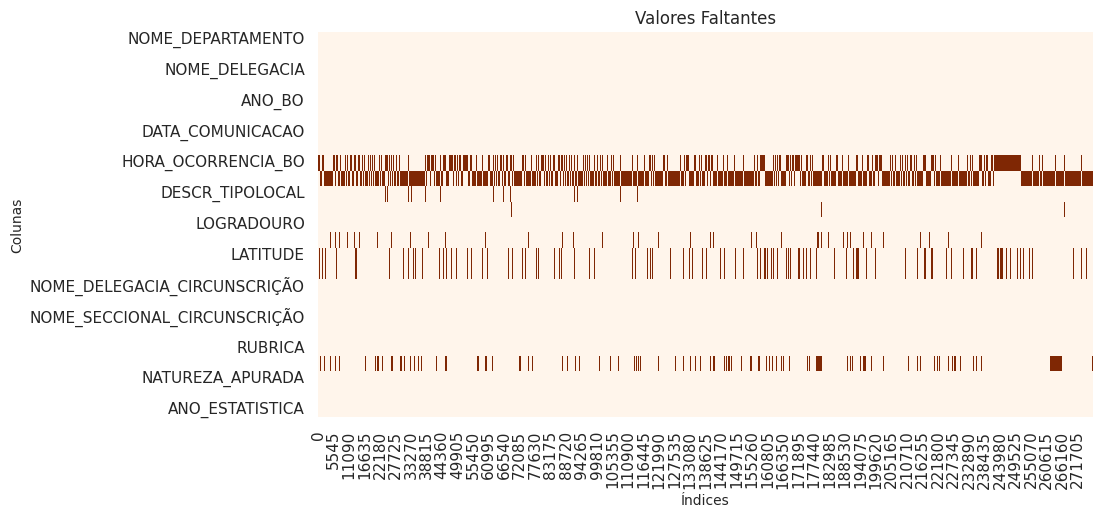

In [20]:
# criando a figura para o gráfico
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

# criando o gráfico
sns.heatmap(dados_criminais.isna().transpose(), cbar=False, ax=ax, cmap='Oranges')

# configurando título e rótulos dos eixos
plt.title('Valores Faltantes', fontsize=12)

plt.xlabel('Índices', fontsize = 10)
plt.ylabel('Colunas', fontsize = 10)
plt.show()

Observamos que algumas colunas possuem valores faltantes, são elas:

- `HORA_OCORRENCIA_BO`
- `DESC_PERIODO`
- `DESCR_TIPOLOCAL`
- `BAIRRO`
- `DESCR_CONDUTA`

Levando em consideração a análise que vamos realizar (clusterização por bairros), o atributo `BAIRRO` é essencial para a nossa análise, por isso vamos olhar os vazios mais de perto. Quanto aos outros, não vamos utilizá-los para essa análise, então vamos mantê-los na base como estão.

Curiosidade: os dados de `HORA_OCORRENCIA_BO` e `DESC_PERIODO` parecem se complementar, no gráfico observa-se que quando faltam valores de hora da ocorrência, existem valores da descrição do período e vice versa.

Agora que checamos todas as colunas, vamos checar e tratar apenas as que vamos utilizar.

In [21]:
# checando os nulos do atributo 'BAIRRO'
total_faltantes = dados_criminais_v1.BAIRRO.isna().sum()

# calculando o percentual de valores faltantes
percentual_faltantes = round((dados_criminais_v1.BAIRRO.isna().sum()/dados_criminais_v1.shape[0])*100, 2)
print(f"No atributo BAIRRO existem {total_faltantes} valores faltantes, representando {percentual_faltantes}% do total.")

No atributo BAIRRO existem 866 valores faltantes, representando 0.31% do total.


Sem esses dados, poderíamos avaliar quais informações possuímos para preencher o campo `BAIRRO`, mas como a quantidade de itens com bairro faltante é abaixo de 0,5%, decidi removê-los.

In [22]:
dados_criminais_v1.dropna(subset=['BAIRRO'], inplace=True)
dados_criminais_v1.isna().sum()

,0
BAIRRO,0
MES_ESTATISTICA,0
NATUREZA_APURADA,0
RUBRICA,2


### 2.4 Observando os atributos no detalhe
Vamos observar as frequências e distribuições, principalmente porque nossos dados são textuais.

#### 2.4.1 Bairro

In [23]:
# checando a contagem dos valores na coluna
dados_criminais_v1.BAIRRO.value_counts()

,count
BAIRRO,
PINHEIROS,6538
BELA VISTA,5610
SANTANA,4813
SANTO AMARO,4770
VILA MARIANA,4746
...,...
RESIDENCIAL CIDADE ALTA,1
CONDOMÍNIO RESIDENCIAL BEIJA-FLOR,1
PARQUE INDUSTRIAL RAMOS DE FREITAS,1


Como podemos observar, existe um valor muito grande de categorias, no total 2481.

Inicialmente vamos realizar uma série de técnicas de pré processamenteo de texto, para ver se assim alguns nomes se unificam.

In [24]:
# deixando todos em caixa alta
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.upper()

dados_criminais_v1.BAIRRO.value_counts().shape[0]

2182

In [25]:
# retirando 'barulhos' do texto
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

dados_criminais_v1.BAIRRO.value_counts().shape[0]

2178

In [26]:
# retirando os caracteres especiais do texto: ã, á, é, ê
to_replace = {'Ã': 'A', 'Á': 'A', 'Â': 'A', 'É': 'E', 'Ê': 'E', 'Ó': 'O', 'Ô': 'O', 'Ú': 'U', 'Í': 'I', 'Ç': 'C'}
for antigo, novo in to_replace.items():
  dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.replace(antigo, novo, regex=True)

dados_criminais_v1.BAIRRO.value_counts().shape[0]

1982

In [27]:
# removendo os excessos de whitespaces e substituindo os espaços duplos por espaços simples
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.strip()
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.replace('  ', ' ', regex=True)


dados_criminais_v1.BAIRRO.value_counts().shape[0]

1979

Além dessas trocas iniciais, vamos observar algumas questões do texto em si, como diversos bairros com `JD` no lugar de `JARDIM`. Itens mapeados:
- `VL` e `VILA`;
- `PQ` e `PARQUE`;
- `PRQ` e `PARQUE`;

Vamos fazer essas alterações.

In [28]:
# com base nos valores da definição
for i, v in zip(dados_criminais_v1.BAIRRO.value_counts().index, dados_criminais_v1.BAIRRO.value_counts().values):
  if 'VL' in i:
    print(i)
  elif 'JD' in i:
    print(i)
  elif 'PQ' in i:
    print(i)

JD SAO LUIS
JD SAO LUIZ
JD BRASIL
JDBRASIL
JD COLONIA
JD VERA CRUZ
JD FILHOS DA TERRA
VL ZILDA
JD LARANJEIRAS
JD FELICIDADE
VL MARIA
JD DOM JOSE
JD BELCITO
PQ LAGOA RICA
JD INDEPENDENCIA
VL RICA
VL POMPEIA
JD ESMERALDA
JD IPANEMA
PQ BANCARIOS
JD SOARES
VL ARICANDUVA
PQ DO CARMO
JD HELENA
VL JAGUARA
JD ROSA CAMPO LIMPO
PQ DO HEROISMO
VL INDUSTRIAL
JD LUCIA
JD SATELITE


In [29]:
# alterando todos os JD para Jardim
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.replace('JD', 'JARDIM', regex=True)
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.replace('VL', 'VILA', regex=True)
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.replace('PQ', 'PARQUE', regex=True)
dados_criminais_v1['BAIRRO'] = dados_criminais_v1['BAIRRO'].str.replace('PRQ', 'PARQUE', regex=True)

dados_criminais_v1.BAIRRO.value_counts().shape[0]

1956

Podemos observar que ainda temos muitas categorias em bairros, mas na nossa base do IBGE temos bem menos, vamos começar a unificar as duas agora.

In [30]:
# checando a base do ibge
ibge_distritos.head()

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,v0001,v0002,v0003,v0004,v0005,v0006,v0007
0,1,Norte,11,Rondônia,1100015,110001505,Alta Floresta D'Oeste,Alta Floresta D'Oeste,34,16744.0,7687.0,7672.0,15.0,2.725596,3.199478,6126.0
1,1,Norte,11,Rondônia,1100015,110001515,Alta Floresta D'Oeste,Filadélfia d'Oeste,3,551.0,330.0,329.0,1.0,2.978378,1.621622,185.0
2,1,Norte,11,Rondônia,1100015,110001520,Alta Floresta D'Oeste,Izidolândia,5,532.0,319.0,319.0,0.0,2.972067,NaN,179.0
3,1,Norte,11,Rondônia,1100015,110001525,Alta Floresta D'Oeste,Nova Gease d'Oeste,19,1175.0,512.0,509.0,3.0,3.245856,2.762431,362.0
4,1,Norte,11,Rondônia,1100015,110001530,Alta Floresta D'Oeste,Rolim de Moura do Guaporé,6,801.0,458.0,458.0,0.0,3.166008,1.185771,253.0


In [31]:
# separando os distritos da cidade de São Paulo da base do IBGE
distritos_saopaulo = ibge_distritos.loc[ibge_distritos['NM_MUN']=='São Paulo', :].copy()
distritos_saopaulo.head()

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,CD_DIST,NM_MUN,NM_DIST,Total_setores,v0001,v0002,v0003,v0004,v0005,v0006,v0007
7222,3,Sudeste,35,São Paulo,3550308,355030801,São Paulo,Água Rasa,174,85788.0,41161.0,41132.0,29.0,2.429346,5.592759,35242.0
7223,3,Sudeste,35,São Paulo,3550308,355030802,São Paulo,Alto de Pinheiros,134,37359.0,17931.0,17911.0,20.0,2.345735,22.081379,15778.0
7224,3,Sudeste,35,São Paulo,3550308,355030803,São Paulo,Anhanguera,191,75360.0,30340.0,30332.0,8.0,2.855474,18.665858,26369.0
7225,3,Sudeste,35,São Paulo,3550308,355030804,São Paulo,Aricanduva,162,89574.0,37225.0,37218.0,7.0,2.773143,15.178544,32289.0
7226,3,Sudeste,35,São Paulo,3550308,355030805,São Paulo,Artur Alvim,203,95575.0,40976.0,40974.0,2.0,2.664900,11.813263,35858.0


Agora vamos ajustar o texto da coluna `NM_DIST` da mesma forma que fizemos com o campo `BAIRRO` na base de dados criminais.

In [32]:
# deixando maísculas
distritos_saopaulo['NM_DIST'] = distritos_saopaulo['NM_DIST'].str.upper()

# retirando caracteres especiais
distritos_saopaulo['NM_DIST'] = distritos_saopaulo['NM_DIST'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

to_replace = {'Ã': 'A', 'Á': 'A', 'Â': 'A', 'É': 'E', 'Ê': 'E', 'Ó': 'O', 'Ô': 'O', 'Ú': 'U', 'Í': 'I', 'Ç': 'C'}
for antigo, novo in to_replace.items():
  distritos_saopaulo['NM_DIST'] = distritos_saopaulo['NM_DIST'].str.replace(antigo, novo, regex=True)

# retirando espaços indesejados
distritos_saopaulo['NM_DIST'] = distritos_saopaulo['NM_DIST'].str.strip()
distritos_saopaulo['NM_DIST'] = distritos_saopaulo['NM_DIST'].str.replace('  ', ' ', regex=True)

# como não há abreviações nesses nomes (olhei um a um por serem poucos) não precisamos da última etapa

Agora com o atributo ajustado, vamos transformar a coluna em uma lista:

In [33]:
distritos_ibge = [i for i in distritos_saopaulo['NM_DIST']]
len(distritos_ibge)

96

Agora vamos criar uma nova coluna binária em `dados_criminais` que dirá se aquele bairro está ou não na lista oficial do IBGE, em seguida vamos checar os que não estiverem nela.

In [34]:
dados_criminais_v1['DISTRITO_IBGE'] = dados_criminais_v1['BAIRRO'].apply(lambda x: True if x in distritos_ibge else False)

In [35]:
dados_criminais_v1['DISTRITO_IBGE'].value_counts()

,count
DISTRITO_IBGE,
True,214767
False,61570


In [36]:
# checando esses bairros não encontrados
dados_criminais_v1.loc[dados_criminais_v1['DISTRITO_IBGE']==False,:]

,BAIRRO,MES_ESTATISTICA,NATUREZA_APURADA,RUBRICA,DISTRITO_IBGE
6,CENTRO HISTORICO DE SAO PAULO,1,FURTO - OUTROS,Furto (art. 155),False
7,CENTRO HISTORICO DE SAO PAULO,1,FURTO - OUTROS,Furto (art. 155),False
14,CENTRO HISTORICO DE SAO PAULO,1,FURTO - OUTROS,Furto (art. 155),False
18,CENTRO,1,FURTO - OUTROS,Furto (art. 155),False
20,CENTRO HISTORICO DE SAO PAULO,1,FURTO - OUTROS,Furto (art. 155),False
...,...,...,...,...,...
277187,VILA HELIOPOLIS,7,TRÁFICO DE ENTORPECENTES,"tráfico drogas (Art.33, caput)",False
277189,RESIDENCIAL SOL NASCENTE,7,TRÁFICO DE ENTORPECENTES,"tráfico drogas (Art.33, caput)",False
277194,JARDIM DOS MANACAS,7,TRÁFICO DE ENTORPECENTES,"tráfico drogas (Art.33, caput)",False
277199,VILA MINERVA,7,TRÁFICO DE ENTORPECENTES,"tráfico drogas (Art.33, caput)",False


Observando os dados, podemos observar que muitos são de bairros que pertencem a determinado distrito. Vamos inserir essa informação manualmente para alguns, através de um dicionário e uma nova coluna chamada `DISTRITO`.

A seguir vamos observar o bairro `CENTRO`.

In [37]:
dados_criminais_v1.loc[dados_criminais_v1['BAIRRO']=='CENTRO', :].shape[0]

1463

In [38]:
dados_criminais_v1.loc[dados_criminais_v1['BAIRRO']=='CENTRO HISTORICO DE SAO PAULO', :].shape[0]

1473

In [39]:
dados_criminais_v1.loc[dados_criminais_v1['BAIRRO']=='SE', :].shape[0]

4133

In [40]:
dados_criminais_v1.loc[dados_criminais_v1['BAIRRO']=='REPUBLICA', :].shape[0]

5806

Como `CENTRO` e `CENTRO HISTORICO DE SAO PAULO` são o mesmo bairro e esse bairro se divide entre os distritos `SÉ` e `REPÚBLICA` vamos alocar o primeiro na `SÉ` e o segundo na `REPÚBLICA`.

De maneira complementar, irei pesquisar os distritos dos bairros com base em uma linha de corte, já que não encontrei uma base consolidada com essa informação.

In [41]:
# checando o total de crimes em 7 meses dos bairros com distritos definidos
dados_criminais_v1.loc[(dados_criminais_v1['DISTRITO_IBGE']==True), 'BAIRRO'].value_counts()

,count
BAIRRO,
PINHEIROS,6544
REPUBLICA,5806
BELA VISTA,5616
CONSOLACAO,5107
BRAS,4888
SANTANA,4813
SANTO AMARO,4779
VILA MARIANA,4751
BARRA FUNDA,4467


In [42]:
dados_criminais_v1.loc[(dados_criminais_v1['DISTRITO_IBGE']==False)&(dados_criminais_v1['BAIRRO']!='CENTRO')&(dados_criminais_v1['BAIRRO']!='CENTRO HISTORICO DE SAO PAULO'),
                       'BAIRRO'].value_counts().head(24)

,count
BAIRRO,
JARDIM COLINA,1409
CANINDE,839
LUZ,777
CAMPOS ELISEOS,720
CERQUEIRA CESAR,713
AGUA BRANCA,671
INTERLAGOS,581
PARQUE ARTUR ALVIM,557
VARZEA DA BARRA FUNDA,535


Pensando no tempo hábil (e no trabalho manual) farei a pesquisa dos bairros com mais de 300 boletins de ocorrência registrados no período (7 meses).

Alguns deles não ficam no município de São Paulo, como `JARDIM COLINA`, esses ficarão sem correspondência e serão removidos depois.

In [43]:
# inicialmente a coluna será igual a bairro, depois começaremos a alterar os valores
dados_criminais_v1['DISTRITO'] = dados_criminais_v1['BAIRRO']

bairro_distrito = {'CENTRO': 'SE', 'CENTRO HISTORICO DE SAO PAULO': 'REPUBLICA', 'CANINDE': 'PARI', 'LUZ': 'BOM RETIRO',
                   'CAMPOS ELISEOS': 'SANTA CECILIA', 'CERQUEIRA CESAR': 'SE', 'AGUA BRANCA': 'BARRA FUNDA',
                   'INTERLAGOS': 'SOCORRO', 'PARQUE ARTUR ALVIM': 'ARTUR ALVIM', 'JARDIM ARTUR ALVIM':'ARTUR ALVIM',
                   'VARZEA DA BARRA FUNDA': 'BARRA FUNDA', 'CIDADE ANTONIO ESTEVAO DE CARVALHO': 'ARTUR ALVIM',
                   'VILA CARMOSINA': 'ITAQUERA', 'JARDIM PAULISTANO': 'PINHEIROS', 'VILA CAMPANELA': 'ITAQUERA',
                   'VILA OLIMPIA': 'ITAIM BIBI', 'VILA BUARQUE': 'CONSOLACAO', 'INDIANOPOLIS': 'MOEMA', 'PARAISO': 'VILA MARIANA',
                   'VILA NOVA CONCEICAO': 'MOEMA', 'SAO MIGUEL PAULISTA': 'SAO MIGUEL', 'VILA GOMES CARDIM': 'TATUAPÉ', 'PENHA DE FRANCA': 'PENHA',
                   'PARQUE DO LAGO': 'JARDIM ANGELA'}

dados_criminais_v1['DISTRITO'] = dados_criminais_v1['DISTRITO'].map(bairro_distrito)

dados_criminais_v1['DISTRITO'] = dados_criminais_v1['DISTRITO'].fillna(value=dados_criminais_v1['BAIRRO'])

In [44]:
dados_criminais_v1.DISTRITO.value_counts()

,count
DISTRITO,
REPUBLICA,7279
PINHEIROS,7041
SE,6309
BARRA FUNDA,5673
BELA VISTA,5616
...,...
TIRADENTES,1
PARQUE BANCARIOS,1
JARDIM NOVA GUAIANAZES,1


Com os valores alterados, vamos criar uma coluna chamada `É DISTRITO` que receberá valores True e False para remover os bairros que não preenchemos os distritos.

In [45]:
dados_criminais_v1['É_DISTRITO'] = dados_criminais_v1['DISTRITO'].apply(lambda x: True if x in distritos_ibge else False)

In [46]:
# comparando as colunas antes de realizar as pesquisas manuais e depois

print(f"Antes das pesquisas manuais:\n\n{dados_criminais_v1['DISTRITO_IBGE'].value_counts()}\n")
print(f"Pós pesquisas manuais:\n\n{dados_criminais_v1['É_DISTRITO'].value_counts()}")

Antes das pesquisas manuais:

DISTRITO_IBGE
True     214767
False     61570
Name: count, dtype: int64

Pós pesquisas manuais:

É_DISTRITO
True     228184
False     48153
Name: count, dtype: int64


In [47]:
# calculando o percentual de valores sem distrito do IBGE
percentual_sem_distrito = round((dados_criminais_v1['É_DISTRITO'].value_counts().values[1]/dados_criminais_v1.shape[0])*100,2)

print(f"{percentual_sem_distrito}f% ficaram sem distrito inicialmente e serão removidos da base.")

17.43f% ficaram sem distrito inicialmente e serão removidos da base.


17% de remoção é um percentual alto, mas como faltam bases específicas e o tempo do projeto é limitado, vou seguir com essa remoção.

No futuro pretendo solicitar essa base junto à prefeitura de São Paulo ou criá-la.

Com essa decisão tomada, vamos remover esses dados da base.

In [48]:
dados_criminais_v1['É_DISTRITO'].value_counts()

,count
É_DISTRITO,
True,228184
False,48153


In [49]:
# criando uma cópia apenas com os distritos de acordo com o IBGE
dados_criminais_v2 = dados_criminais_v1.loc[dados_criminais_v1['É_DISTRITO']==True, :].copy()
dados_criminais_v2.shape

(228184, 7)

Com essa etapa realizada, vamos manter apenas a coluna de Distrito que iremos utilizar.

In [50]:
dados_criminais_v2.drop(labels=['BAIRRO', 'DISTRITO_IBGE', 'É_DISTRITO'], axis=1, inplace=True)
dados_criminais_v2.head()

,MES_ESTATISTICA,NATUREZA_APURADA,RUBRICA,DISTRITO
0,1,ESTUPRO DE VULNERÁVEL,Estupro de vulneravel (art.217-A),SE
1,1,FURTO - OUTROS,Furto (art. 155),JARDIM PAULISTA
2,1,FURTO - OUTROS,Furto (art. 155),SE
3,1,FURTO - OUTROS,Furto (art. 155),MOOCA
4,1,FURTO - OUTROS,Furto (art. 155),SE


#### 2.4.2 Natureza Apurada e Rubrica

Primeiro vamos ver a contagem de valores das duas colunas.

In [51]:
dados_criminais_v2['NATUREZA_APURADA'].value_counts()

,count
NATUREZA_APURADA,
FURTO - OUTROS,118851
ROUBO - OUTROS,55725
FURTO DE VEÍCULO,19954
LESÃO CORPORAL DOLOSA,16079
LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,6076
ROUBO DE VEÍCULO,4872
TRÁFICO DE ENTORPECENTES,2239
ESTUPRO DE VULNERÁVEL,886
ROUBO DE CARGA,795


In [52]:
dados_criminais_v2['RUBRICA'].value_counts()

,count
RUBRICA,
Furto (art. 155),138826
Roubo (art. 157),61409
Lesão corporal (art. 129),16394
Lesão corporal culposa na direção de veículo automotor (Art. 303),6077
"Drogas sem autorização ou em desacordo (Art.33, caput)",1701
Estupro de vulneravel (art.217-A),886
"tráfico drogas (Art.33, caput)",705
"Drogas para consumo pessoal sem autorização ou em desacordo (Art.28,caput)",447
Homicídio (art. 121),404


Observando os valores das duas colunas, vamos seguir com `NATUREZA APURADA` como principal, já que possui as categorias bem definidas e provavelmente foi a informação mais atualizada e publicada, por ser chamada de 'Natureza da Publicação'.

 Além disso podemos ver que há necessidade de unificar algumas categorias, por isso vamos tratar essa coluna de maneira similar à como tratamos a coluna `BAIRRO`

In [53]:
# retirando caracteres especiais
dados_criminais_v2['NATUREZA_APURADA'] = dados_criminais_v2['NATUREZA_APURADA'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

to_replace = {'Ã': 'A', 'Á': 'A', 'Â': 'A', 'É': 'E', 'Ê': 'E', 'Ó': 'O', 'Ô': 'O', 'Ú': 'U', 'Í': 'I', 'Ç': 'C'}

for antigo, novo in to_replace.items():
  dados_criminais_v2['NATUREZA_APURADA'] = dados_criminais_v2['NATUREZA_APURADA'].str.replace(antigo, novo, regex=True)

# retirando espaços indesejados
dados_criminais_v2['NATUREZA_APURADA'] = dados_criminais_v2['NATUREZA_APURADA'].str.strip()
dados_criminais_v2['NATUREZA_APURADA'] = dados_criminais_v2['NATUREZA_APURADA'].str.replace('  ', ' ', regex=True)

# como não há abreviações nesses nomes (olhei um a um por serem poucos) não precisamos da última etapa

Vamos dar uma olhada na quantidade absoluta de itens através de um gráfico de barras com a contagem de cada delito.

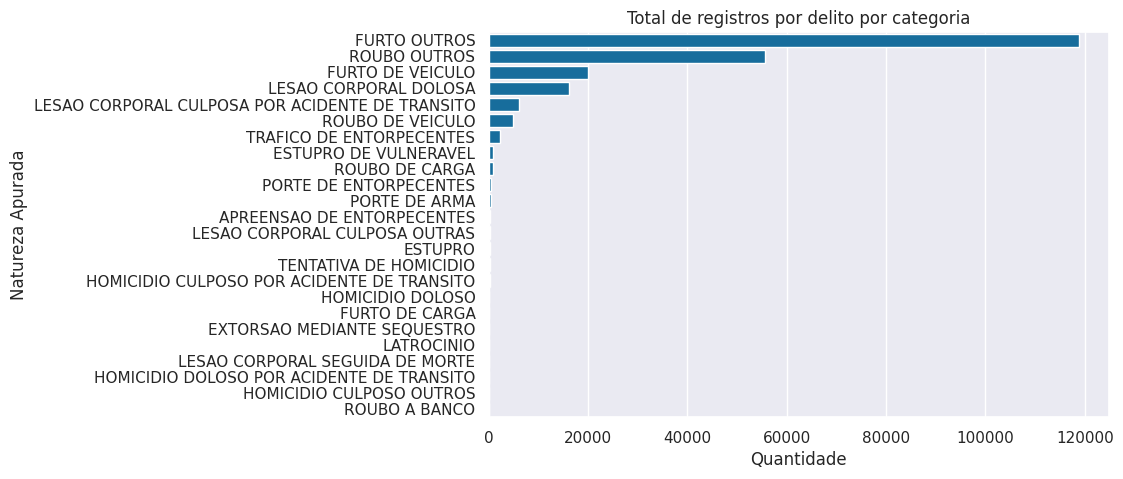

In [54]:
# agrupando os dados por Natureza Apurada, que são os delitos
grupo_natureza = dados_criminais_v2.groupby(by=['NATUREZA_APURADA']).count()

# organizando os dados para o gráfico, em ordem decrescente
grupo_natureza.sort_values(by='DISTRITO', inplace=True, ascending=False)

# montando o gráfico, com tamanho definido, usando seaborn
fig = plt.figure(figsize=(8, 5))
sns.barplot(y=grupo_natureza.index,x=grupo_natureza['DISTRITO'])

# adicionando elementos textuais no gráfico
plt.title('Total de registros por delito por categoria')
plt.xlabel('Quantidade')
plt.ylabel('Natureza Apurada')

plt.show()

No gráfico acima podemos observar uma quantidade muito maior de Furtos nos 7 meses agrupados. Agora vamos plotar um gráfico para cada mês, assim vamos ver melhor a distribuição e se esse padrão se repete.

Inicialmente vamos agrupar a base por Natureza e Mês.

In [55]:
# agrupando por natureza apurada & mes estatistica
grupo_mes = dados_criminais_v2.groupby(by=['NATUREZA_APURADA', 'MES_ESTATISTICA']).count()

# transformando os indices em colunas
grupo_mes = grupo_mes.reset_index(drop=False)

grupo_mes.head()

,NATUREZA_APURADA,MES_ESTATISTICA,RUBRICA,DISTRITO
0,APREENSAO DE ENTORPECENTES,1,46,46
1,APREENSAO DE ENTORPECENTES,2,42,42
2,APREENSAO DE ENTORPECENTES,3,54,54
3,APREENSAO DE ENTORPECENTES,4,49,49
4,APREENSAO DE ENTORPECENTES,5,43,43


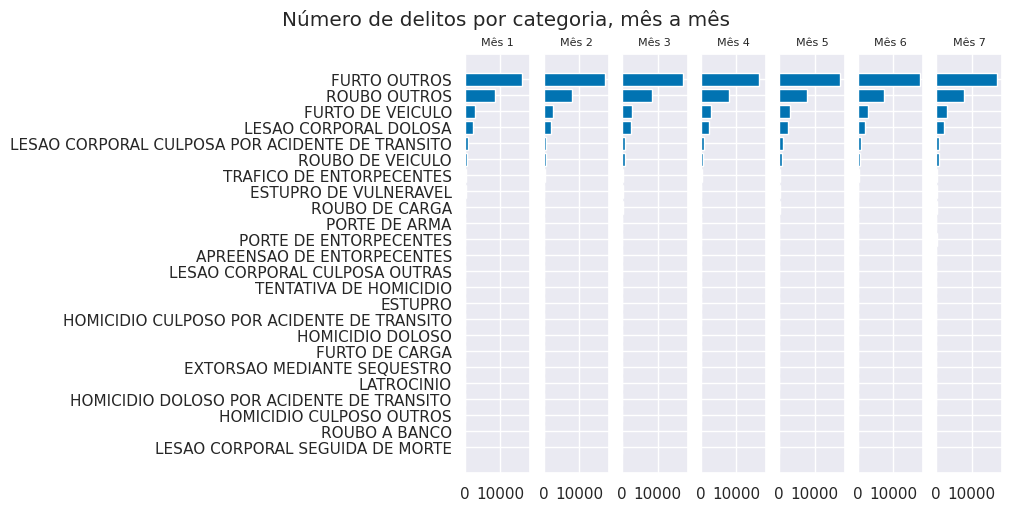

In [56]:
fig, ax = plt.subplots(nrows = 1, ncols = 7, sharex='all', sharey='all', figsize=(10,5), constrained_layout=True)

fig.suptitle("Número de delitos por categoria, mês a mês")

s = 1
while s < 8:
  for t in range(7):
    ax[t].barh(data=grupo_mes.loc[grupo_mes['MES_ESTATISTICA']== s,:].sort_values(by=['DISTRITO'], ascending=False),
               width='DISTRITO', y='NATUREZA_APURADA')
    ax[t].invert_yaxis()
    ax[t].set_title(f"Mês {s}", fontsize=8)
    s += 1

plt.show()

Como podemos observar nos gráficos, as 4 primeiras categorias se destacam, por isso vamos plotar outro gráfico sem essas 4 categorias.

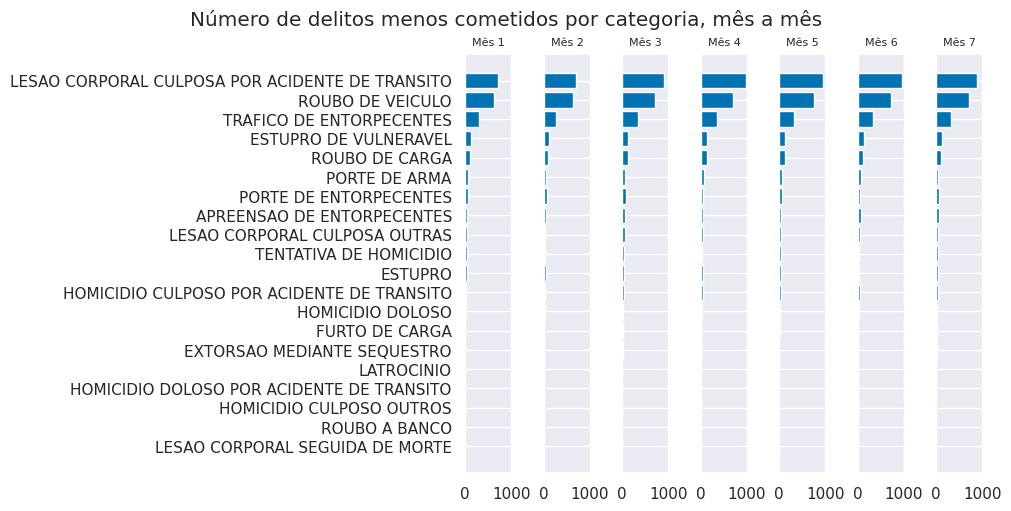

In [57]:
# categorias para remover
destaque = ['FURTO OUTROS', 'ROUBO OUTROS', 'FURTO DE VEICULO', 'LESAO CORPORAL DOLOSA']

# criando lista sem os destaques
sem_destaque = [i for i in grupo_mes['NATUREZA_APURADA'].unique() if i not in destaque]

df_sem_destaque = grupo_mes[grupo_mes.NATUREZA_APURADA.isin(sem_destaque)]

# plotando os gráficos das categorias sem destaque
fig, ax = plt.subplots(nrows = 1, ncols = 7, sharex='all', sharey='all', figsize=(10,5), constrained_layout=True)

fig.suptitle("Número de delitos menos cometidos por categoria, mês a mês")

# criando um loop para preencher os subplots
s = 1
while s < 8:
  for t in range(7):
    df = df_sem_destaque.loc[df_sem_destaque['MES_ESTATISTICA']== s,:].sort_values(by=['DISTRITO'], ascending=False)
    ax[t].barh(data=df,
               width='DISTRITO', y='NATUREZA_APURADA')
    ax[t].invert_yaxis()
    ax[t].set_title(f"Mês {s}", fontsize=8)
    s += 1

plt.show()

De maneira curiosa os valores parecem muito similares ao longo dos meses. Vamos preparar os dados mantendo as instâncias como boletins de ocorrência, sem os códigos, para manter a maior quantidade de dados possível.

Agora vamos remover a coluna `RUBRICA` e seguir para os próximos passos.

In [58]:
dados_criminais_v3 = dados_criminais_v2.drop(labels=['RUBRICA'], axis=1)
dados_criminais_v3.head()

,MES_ESTATISTICA,NATUREZA_APURADA,DISTRITO
0,1,ESTUPRO DE VULNERAVEL,SE
1,1,FURTO OUTROS,JARDIM PAULISTA
2,1,FURTO OUTROS,SE
3,1,FURTO OUTROS,MOOCA
4,1,FURTO OUTROS,SE


#### 2.4.4 Distritos & Delitos
Com a coluna Natureza Apurada definida, vamos observar o comportamento dos delitos por distrito, mês a mês.

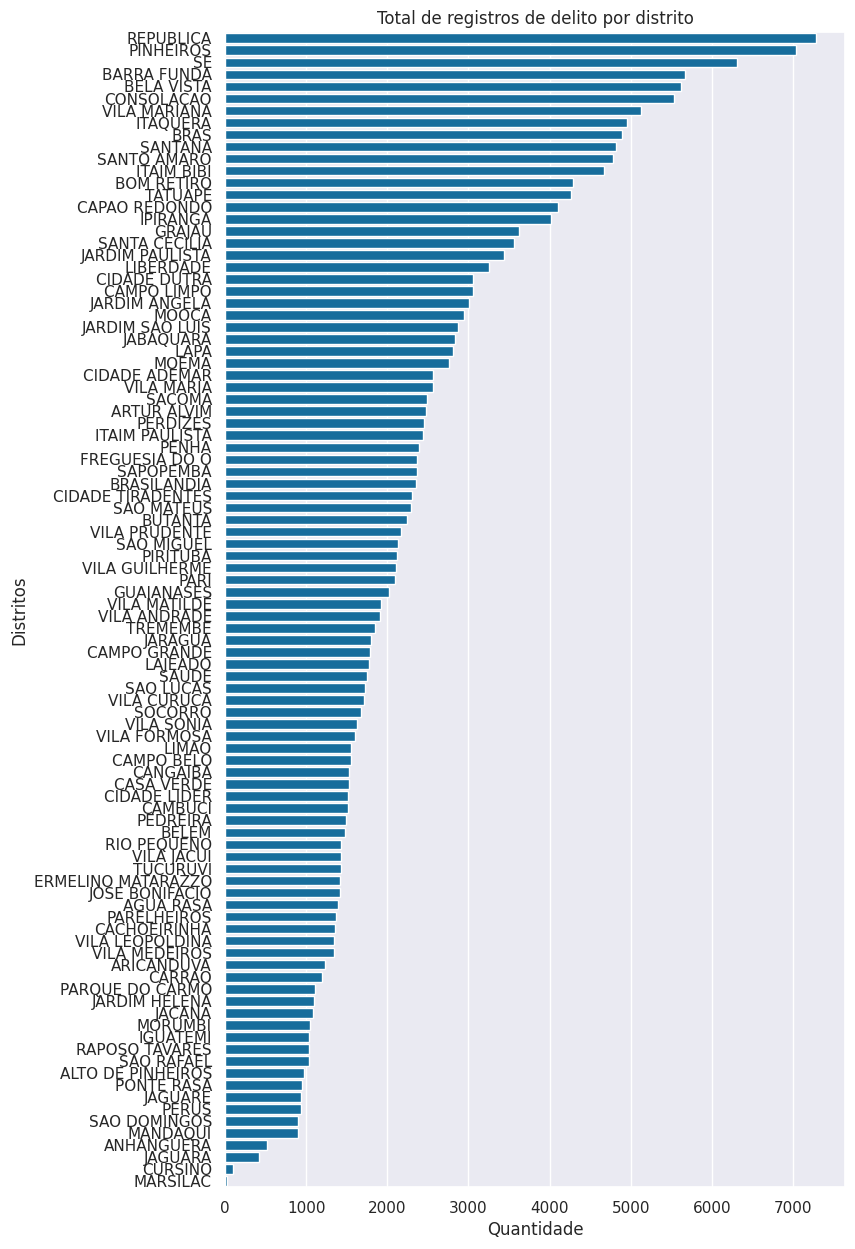

In [59]:
# agrupando os dados por Natureza Apurada, que são os delitos
grupo_distrito = dados_criminais_v2.groupby(by=['DISTRITO']).count()

# organizando os dados para o gráfico, em ordem decrescente
grupo_distrito.sort_values(by='NATUREZA_APURADA', inplace=True, ascending=False)

# montando o gráfico, com tamanho definido, usando seaborn
fig = plt.figure(figsize=(8, 15))
sns.barplot(y=grupo_distrito.index,x=grupo_distrito['NATUREZA_APURADA'])

# adicionando elementos textuais no gráfico
plt.title('Total de registros de delito por distrito')
plt.xlabel('Quantidade')
plt.ylabel('Distritos')

plt.show()

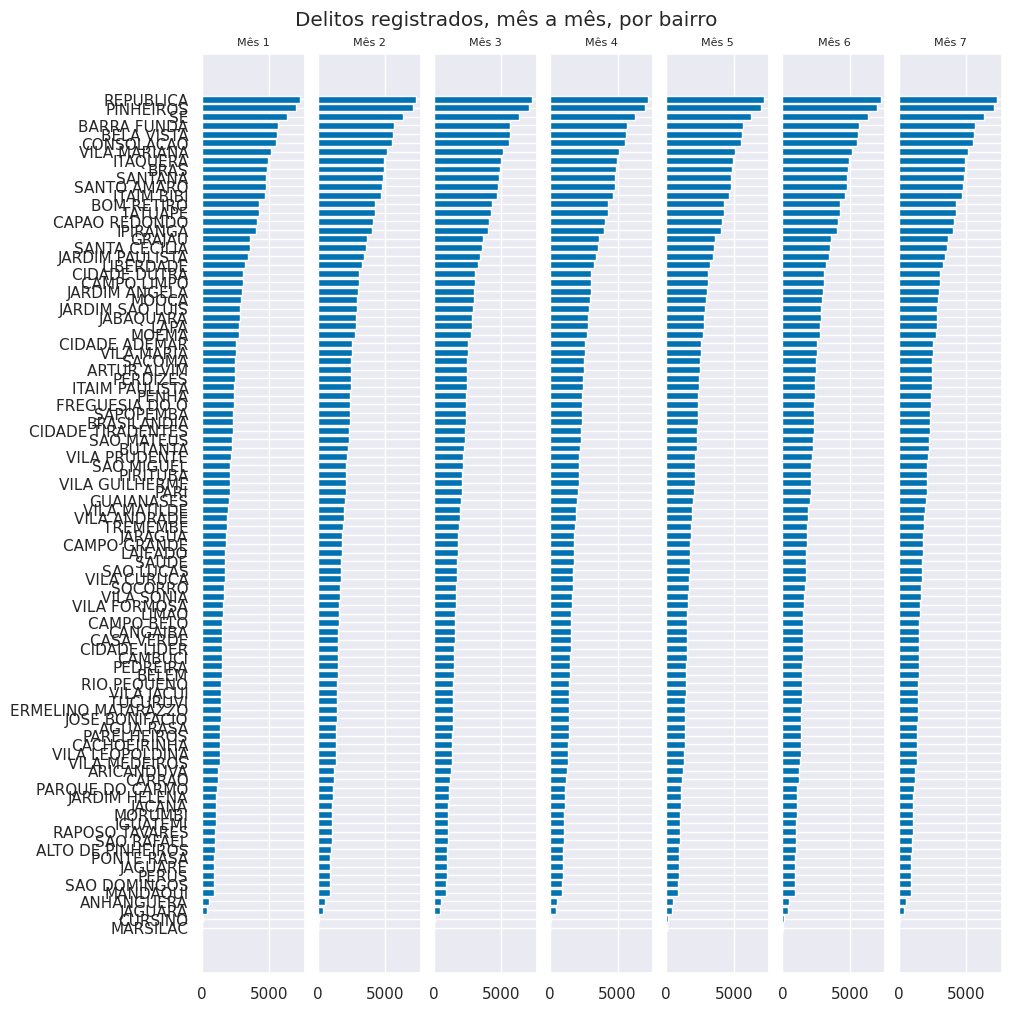

In [60]:
# plotando um gráfico para cada mês

# plotando os gráficos mês a mês
fig, ax = plt.subplots(nrows = 1, ncols = 7, sharex='all', sharey='all', figsize=(10,10), constrained_layout=True)

# criando um loop para preencher os subplots
s = 1
while s < 8:
  for t in range(7):
    ax[t].barh(width=grupo_distrito.NATUREZA_APURADA.values, y=grupo_distrito.index)
    ax[t].invert_yaxis()
    ax[t].set_title(f"Mês {s}", fontsize=8)
    s += 1

fig.suptitle("Delitos registrados, mês a mês, por bairro")

plt.show()

Podemos ver que os dados se comportam de maneira bastante similar, mês a mês.
Agora vamos dar uma olhada nos delitos agrupados por distrito e natureza apurada.

In [61]:
# criando a base agrupada por distrito e natureza apurada
distritos = dados_criminais_v3.groupby(by=['DISTRITO', 'NATUREZA_APURADA']).count().reset_index(drop=False)
distritos = distritos.sort_values(by=['MES_ESTATISTICA'], ascending=False)
distritos

,DISTRITO,NATUREZA_APURADA,MES_ESTATISTICA
1039,PINHEIROS,FURTO OUTROS,4718
1336,SE,FURTO OUTROS,4453
1110,REPUBLICA,FURTO OUTROS,4231
82,BARRA FUNDA,FURTO OUTROS,4123
427,CONSOLACAO,FURTO OUTROS,3781
...,...,...,...
1424,VILA ANDRADE,LESAO CORPORAL CULPOSA OUTRAS,1
317,CARRAO,APREENSAO DE ENTORPECENTES,1
306,CAPAO REDONDO,LATROCINIO,1
741,JARDIM PAULISTA,ROUBO DE CARGA,1


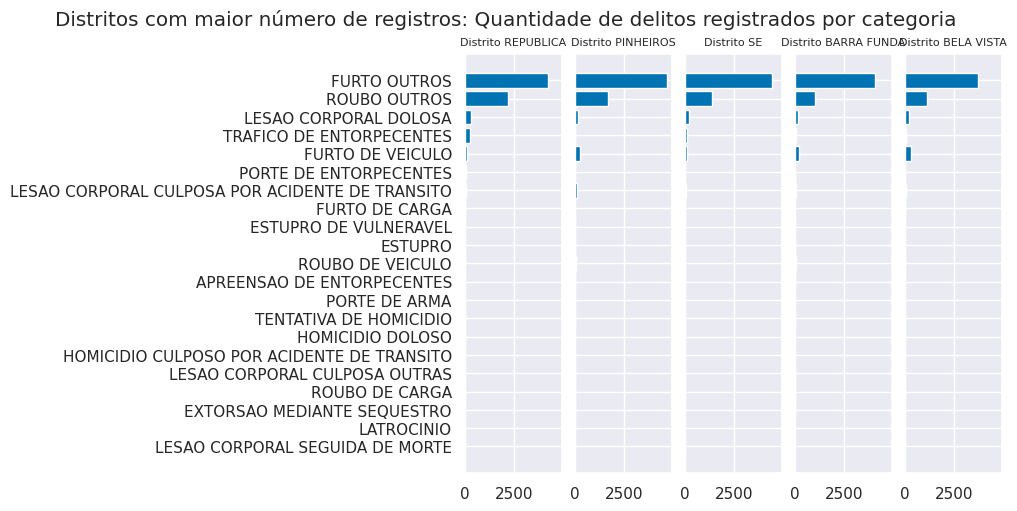

In [62]:
# plotando um gráfico para cada distrito
fig, ax = plt.subplots(nrows = 1, ncols = 5, sharex='all', sharey='all', figsize=(10,5), constrained_layout=True)

# gerando a lista de distritos principais
principais = ['REPUBLICA', 'PINHEIROS', 'SE', 'BARRA FUNDA', 'BELA VISTA']

# criando um loop para preencher os subplots
for p, t in zip(principais, range(5)):
  df = distritos[distritos['DISTRITO']==p]
  ax[t].barh(data=df, width='MES_ESTATISTICA', y='NATUREZA_APURADA')
  ax[t].invert_yaxis()
  ax[t].set_title(f"Distrito {p}", fontsize=8)

fig.suptitle("Distritos com maior número de registros: Quantidade de delitos registrados por categoria")

plt.show()

Nos gráficos acima podemos observar que por mais que Republica e Pinheiros possuam um volume de registros muito pareciso, existe uma diferença significante no tipo de crimes.

República possui valores mais altos que Pinheiros em Roubo, Lesão Corporal Dolosa e Tráfico de Entorpecentes. Enquanto Pinheiros tem valores mais altos que República em Furto, Furto de Veículo e Lesão Corporal Culposa por Acidente de Trânsito. Os crimes são de natureza muito distinta.

Barra Funda e Bela Vista se assemelham um pouco mais a Pinheiros, enquanto Sé se aproxima de República, mas com valores mais baixos.

#### 2.4.5 Crimes mais cometidos nos distritos com maior número de crimes registrados
Nesse momento vamos observar um pouco mais de perto quais crimes foram cometidos nos 5 bairros com maior número de crimes registrados: República, Pinheiros, Sé, Barra Funda e Bela Vista.
Vamos plotar gráficos de barra para checar as informações.

### 3. Pré processamento de dados: Preparando para Clusterização

Para os nossos dados serem compatíveis com o algoritmo, devemos possuir apenas valores numéricos, para isso teremos que utilizar, principalmente, One Hot Encoding para transformar a coluna `NATUREZA_APURADA`.

Como iremos criar um modelo não supervisionado, não há necessidade de separar treino e teste antes desse momento.

In [63]:
dados_criminais_v3.head()

,MES_ESTATISTICA,NATUREZA_APURADA,DISTRITO
0,1,ESTUPRO DE VULNERAVEL,SE
1,1,FURTO OUTROS,JARDIM PAULISTA
2,1,FURTO OUTROS,SE
3,1,FURTO OUTROS,MOOCA
4,1,FURTO OUTROS,SE


Primeiro vamos recortar a base de dados para possuir apenas a `NATUREZA_APURADA` que é o atributo que vamos usar para clusterizar.
Primeiro vamos checar a quantidade de categorias, para conferir os resultados no futuro.

In [64]:
# criando a lista
naturezas = [i for i in dados_criminais_v3['NATUREZA_APURADA'].unique()]

# mostrando o tamanho
len(naturezas)

24

In [65]:
# usando one hot encoding na coluna de Natureza Apurada

# definindo o transformador
encoder = OneHotEncoder(sparse_output=False)

# mantendo apenas a coluna NATUREZA_APURADA
naturezas_criminais = dados_criminais_v3.drop(labels=['MES_ESTATISTICA', 'DISTRITO'], axis=1)

# transformando os dados
onehot = encoder.fit_transform(naturezas_criminais)
print(onehot)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [66]:
# transformando o objeto one hot encoded em uma dataframe
onehotencoded = pd.DataFrame(onehot)

# conferindo seu tamanho
onehotencoded.shape

(228184, 24)

In [67]:
# checando a dataframe original
dados_criminais_v3.shape

(228184, 3)

Agora nos resta utilizar esses dados no algoritmo de Clusterização.

# Conclusão

Ao longo da análise pudemos observar que os distritos de São Paulo possuíram um volume de delitos similares ao longo dos 7 primeiros meses de 2024, sem grandes flutuações nos distritos nem nos tipos de crimes.
Além disso os bairros com maior número de delitos registrados foram: República, Pinheiros, Sé, Barra Funda e Boa Vista. O crime mais cometido foi Furto, seguido de Roubo.

Nesses 5 bairros pudemos observar diferenças significativas na natureza dos crimes, essas diferença podem ser bem relevantes quando realizarmos a clusterização.

**Possíveis próximos passos**

Nesse MVP fizemos o tratamento dos dados mais importantes da base criminal da cidade de São Paulo, muitas são as possibilidades com vários atributos que existem nessa base, esse projeto poderia durar por muitos meses.

Gostaria de adicionar alguns próximos passos que eu realizaria, caso dedicasse mais tempo a esse projeto (o que talvez aconteça):
- Adicionar informações sobre o período do dia em que o crime foi cometido
- Adicionar informações populacionais aos distritos
- Enriquecer mais a relação entre os bairros e distritos, com uma nova base de dados oficial
- Adicionar a dimensionalidade dos dias da semana que os crimes acontecem
- Aumentar a quantiade de dados, adicionando os anos de 2023, 2022 e 2022 e, com esses dados novos, investigar sazonalidade e tendênciais


A lista pode se extender ainda mais, com mais horas poderíamos deixar o modelo e os estudos mais precisos, adicionando dados complementares para seguir as diretrizes do Manual para Interpretação de Dados Criminais, como por exemplo:
- Adicionar um indicador de maior probabilidade de Cifra Negra nos crimes que são menos reportados;
- Adicionar informações sobre população flutuante para ser mais precisos em relação à densidade populacional;
- Buscar dados de desenvolvimento humano e econômicos dos distritos, para realizar uma análise mais fidedigna à realidade;
- Adicionar graus de violência atrelados aos crimes, como um peso maior a homicídios do que a furtos ou o índice de criminalidade;